# 1. Packages

First, I imported all packages that are needed to be used.

In [146]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from util import *
from logistic_regression import *

%matplotlib inline

# 2. Data

Here, I loaded the dataset.

In [147]:
X1, y1 = load_data("data/processed/dataset_1.csv")
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2, y2 = load_data("data/processed/dataset_2.csv")
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

X3, y3 = load_data("data/processed/dataset_3.csv")
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

Then, I check the type of the first data.

In [148]:
print(type(X1_train), type(y1_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


After that, I checked the dimensions of the first data.

In [149]:
print("The shape of X1_train is: ", X1_train.shape)
print("The shape of y1_train is: ", y1_train.shape)

The shape of X1_train is:  (455, 30)
The shape of y1_train is:  (455,)


I did the same thing with the second and the third data.

In [61]:
print(type(X2_train), type(y2_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [62]:
print("The shape of X2_train is: ", X2_train.shape)
print("The shape of y2_train is: ", y2_train.shape)

The shape of X2_train is:  (5634, 2)
The shape of y2_train is:  (5634,)


In [150]:
print(type(X3_train), type(y3_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [151]:
print("The shape of X3_train is: ", X3_train.shape)
print("The shape of y3_train is: ", y3_train.shape)

The shape of X3_train is:  (800, 5)
The shape of y3_train is:  (800,)


# 3. Model training

## 3.1. First dataset

In [131]:
my_lr = MyLogisticRegression(0.01, 500, 2)
my_lr.fit(X1_train, y1_train)

Iteration    0: Cost     0.69   
Iteration   50: Cost     0.08   
Iteration  100: Cost     0.08   
Iteration  150: Cost     0.08   
Iteration  200: Cost     0.08   
Iteration  250: Cost     0.08   
Iteration  300: Cost     0.08   
Iteration  350: Cost     0.08   
Iteration  400: Cost     0.08   
Iteration  450: Cost     0.08   
Iteration  499: Cost     0.08   


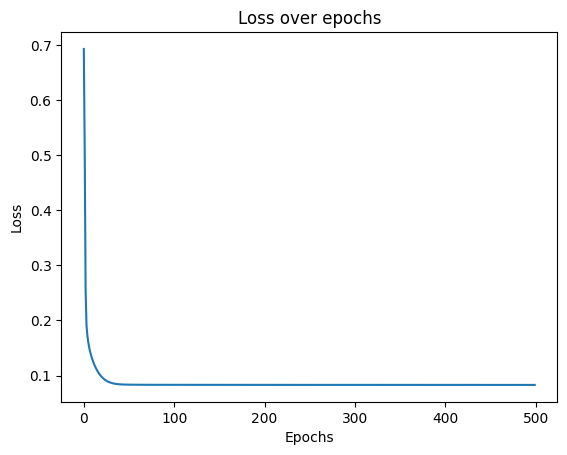

In [132]:
my_lr.plot_loss()

In [143]:
y1_pred = my_lr.predict(X1_test)
print("The accuracy of my model for the first dataset is: ", accuracy_score(y1_test, y1_pred))
print("The f1 score of my model for the first dataset is: ", f1_score(y1_test, y1_pred))

The accuracy of my model for the first dataset is:  0.9824561403508771
The f1 score of my model for the first dataset is:  0.9767441860465116


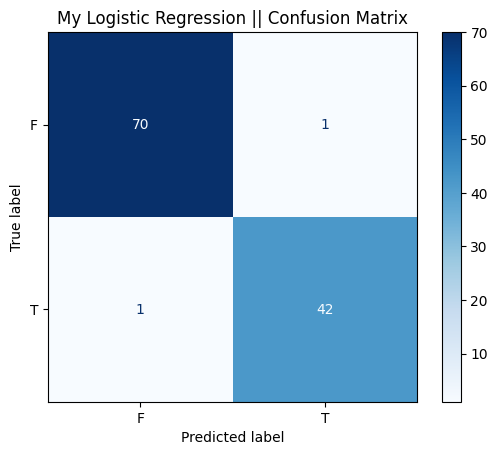

In [134]:
my_cm1 = confusion_matrix(y1_test, y1_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=my_cm1,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title('My Logistic Regression || Confusion Matrix')
plt.show()

In [142]:
lr = LogisticRegression(solver='saga', max_iter=500, penalty='l2', C=0.5)
lr.fit(X1_train, y1_train)
y1_pred_lr = lr.predict(X1_test)
print("The accuracy of sklearn's model for the first dataset is: ", accuracy_score(y1_test, y1_pred_lr))
print("The f1 score of sklearn's model for the first dataset is: ", f1_score(y1_test, y1_pred_lr))

The accuracy of sklearn's model for the first dataset is:  0.9824561403508771
The f1 score of sklearn's model for the first dataset is:  0.9761904761904763


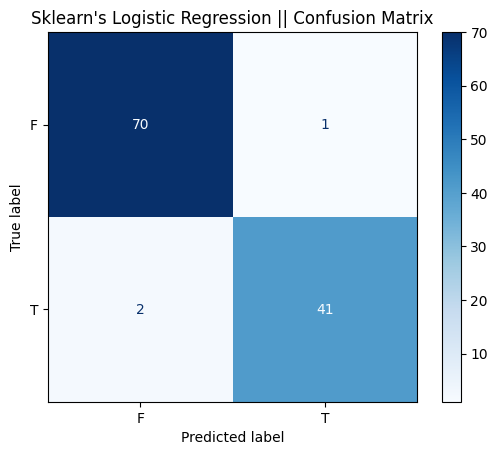

In [129]:
cm1 = confusion_matrix(y1_test, y1_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title("Sklearn's Logistic Regression || Confusion Matrix")
plt.show()

## 3.2. Second dataset

In [117]:
my_lr2 = MyLogisticRegression(0.001, 10000, 1)
my_lr2.fit(X2_train, y2_train)

Iteration    0: Cost     0.69   
Iteration 1000: Cost     0.56   
Iteration 2000: Cost     0.53   
Iteration 3000: Cost     0.51   
Iteration 4000: Cost     0.50   
Iteration 5000: Cost     0.49   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.48   
Iteration 8000: Cost     0.47   
Iteration 9000: Cost     0.47   
Iteration 9999: Cost     0.47   


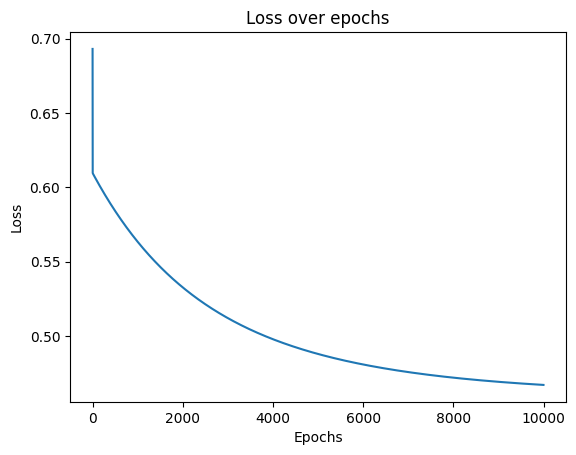

In [118]:
my_lr2.plot_loss()

In [144]:
y2_pred = my_lr2.predict(X2_test)
print("The accuracy of my model for the second dataset is: ", accuracy_score(y2_test, y2_pred))
print("The f1 score of my model for the second dataset is: ", f1_score(y2_test, y2_pred))

The accuracy of my model for the second dataset is:  0.7885024840312278
The f1 score of my model for the second dataset is:  0.57183908045977


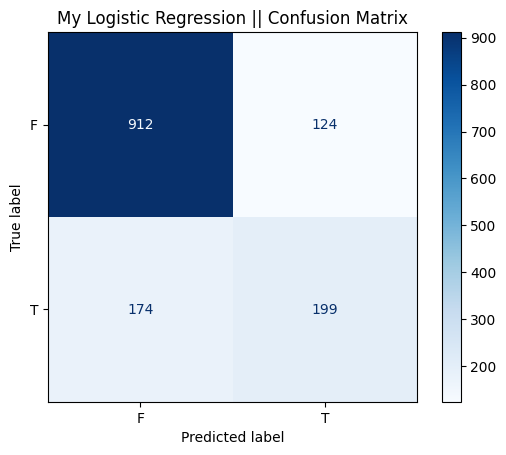

In [139]:
my_cm2 = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=my_cm2,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title('My Logistic Regression || Confusion Matrix')
plt.show()

In [135]:
lr2 = LogisticRegression(solver='saga', max_iter=10000, penalty='l2', C=1)
lr2.fit(X2_train, y2_train)

LogisticRegression(C=1, max_iter=10000, solver='saga')

In [145]:
y2_pred_lr = lr2.predict(X2_test)
print("The accuracy of sklearn's model for the second dataset is: ", accuracy_score(y2_test, y2_pred_lr))
print("The f1 score of sklearn's model for the second dataset is: ", f1_score(y2_test, y2_pred_lr))

The accuracy of sklearn's model for the second dataset is:  0.7984386089425124
The f1 score of sklearn's model for the second dataset is:  0.5590062111801243


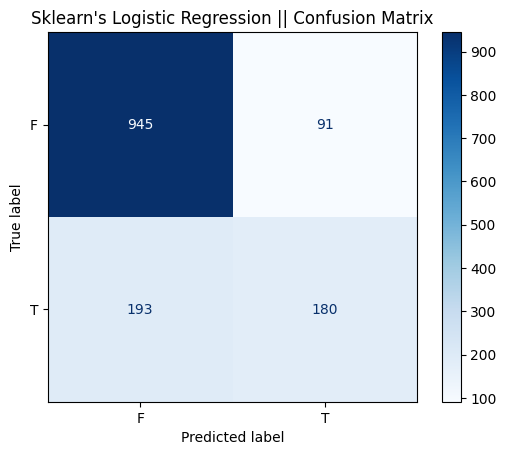

In [137]:
cm2 = confusion_matrix(y2_test, y2_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title("Sklearn's Logistic Regression || Confusion Matrix")
plt.show()

## 3.3. Third dataset

In [156]:
my_lr3 = MyLogisticRegression(0.001, 1000, 1)
my_lr3.fit(X3_train, y3_train)

Iteration    0: Cost     0.69   
Iteration  100: Cost     0.11   
Iteration  200: Cost     0.11   
Iteration  300: Cost     0.11   
Iteration  400: Cost     0.11   
Iteration  500: Cost     0.11   
Iteration  600: Cost     0.11   
Iteration  700: Cost     0.11   
Iteration  800: Cost     0.11   
Iteration  900: Cost     0.11   
Iteration  999: Cost     0.11   


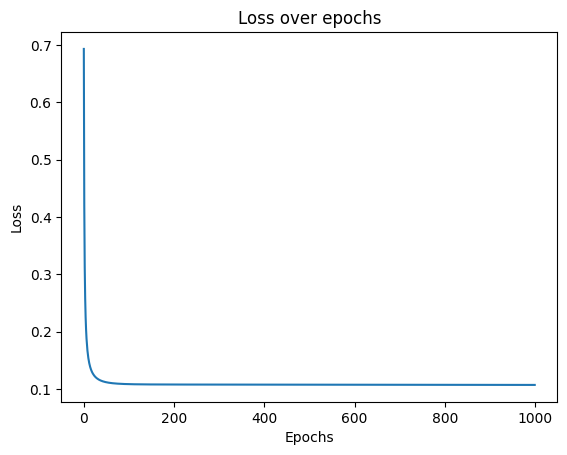

In [157]:
my_lr3.plot_loss()

In [158]:
y3_pred = my_lr3.predict(X3_test)
print("The accuracy of my model for the third dataset is: ", accuracy_score(y3_test, y3_pred))
print("The f1 score of my model for the third dataset is: ", f1_score(y3_test, y3_pred))

The accuracy of my model for the third dataset is:  0.93
The f1 score of my model for the third dataset is:  0.9339622641509434


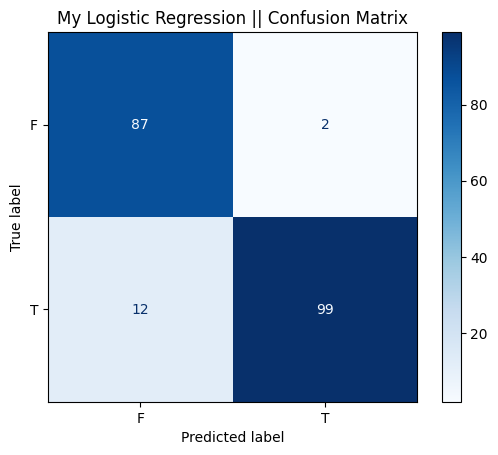

In [159]:
my_cm3 = confusion_matrix(y3_test, y3_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=my_cm3,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title('My Logistic Regression || Confusion Matrix')
plt.show()

In [160]:
lr3 = LogisticRegression(solver='saga', max_iter=1000, penalty='l2', C=1)
lr3.fit(X3_train, y3_train)

LogisticRegression(C=1, max_iter=1000, solver='saga')

In [161]:
y3_pred_lr = lr3.predict(X3_test)
print("The accuracy of sklearn's model for the third dataset is: ", accuracy_score(y3_test, y3_pred_lr))
print("The f1 score of sklearn's model for the third dataset is: ", f1_score(y3_test, y3_pred_lr))

The accuracy of sklearn's model for the third dataset is:  0.96
The f1 score of sklearn's model for the third dataset is:  0.9636363636363636


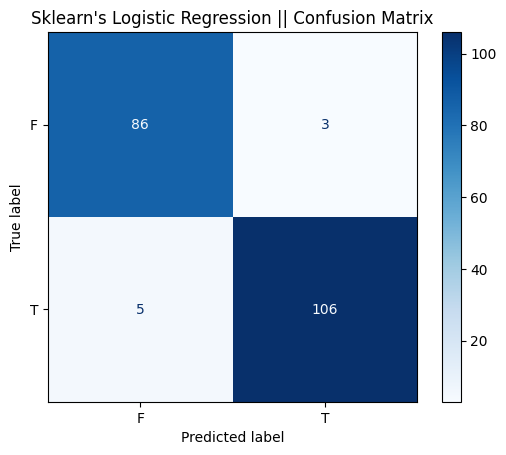

In [162]:
cm3 = confusion_matrix(y3_test, y3_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title("Sklearn's Logistic Regression || Confusion Matrix")
plt.show()

# 4. Conclusions

- In the first dataset, with the same set of hyperparameters (maximum number of epoches = 500, regularization type = l2, regularization = 2), my Logistic Regression model has the similar accuracy as the sklearn's model. Not only that, the ConfusionMatrix also shows that the number of True Positives (TP), True Negatives (TN), False Positive (FP), and False Negatives (FN) are the same between 2 models.
- In the second dataset, with the same set of hyperparameters (maximum number of epoches = 10000, regularization type = l2, regularization = 1), my model's accuracy is lower than that of sklearn's, but the F1-score is higher.
- In the third dataset, with the same set of initialization, my model's accuracy and F1 score is lower than sklearn's.